In [1]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import math

%matplotlib inline

I read this discussion thread about PCEN as an alternative to mel-scale filters - [Anyone tried PCEN in front end?](https://www.kaggle.com/c/freesound-audio-tagging-2019/discussion/91859) and thought I'd give it a go.


### Load an example wav file and compute the melspectrogram features

In [2]:
slice_len   = 2
slice_count = 1
sr          = 44100
n_mels      = 256
fmin        = 20
hop_length  = int(sr/(n_mels/slice_len)) # ensures square mel-spectrogram slice
fmax        = sr//2

y = librosa.effects.trim(librosa.load('../input/train_noisy/42f7abb4.wav' , sr)[0])[0]

s = librosa.feature.melspectrogram(y, 
                                   sr         = sr,
                                   n_mels     = n_mels,
                                   hop_length = hop_length,
                                   n_fft      = n_mels*20,
                                   fmin       = fmin,
                                   fmax       = fmax)

### Compute PCEN from mels


As suggested in the thread I tried out a few different sets of parameters using the [librosa implementation](https://librosa.github.io/librosa/generated/librosa.core.pcen.html) mentioned in the thread. I found some parameters that seemed to give me a bit of a boost over the '''power_to_db''' function that I had been using. Those parameters were:
```
gain          = 0.6
bias          = 0.1 
power         = 0.2 
time_constant = 0.4 
eps           = 1e-9
```

In [3]:
gain          = 0.6
bias          = 0.1 
power         = 0.2 
time_constant = 0.4 
eps           = 1e-9

time_constant = 0.4

power_to_db = librosa.power_to_db(s)

pcen_librosa = librosa.core.pcen(s, 
                                 sr            = sr,
                                 hop_length    = hop_length,
                                 gain          = gain,
                                 bias          = bias,
                                 power         = power,
                                 time_constant = time_constant,
                                 eps           = eps)



### Compare plots of the Power to Db and the PCEN mel-spectrogram 

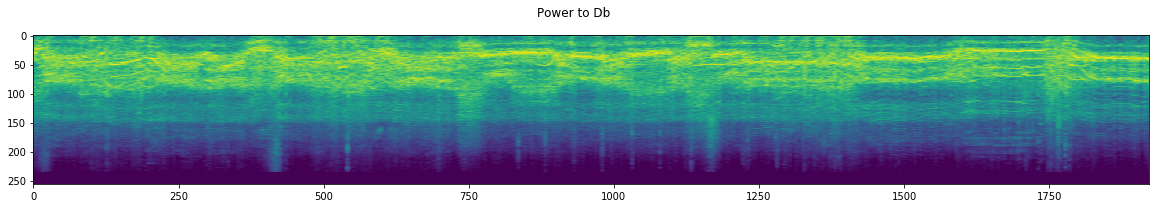

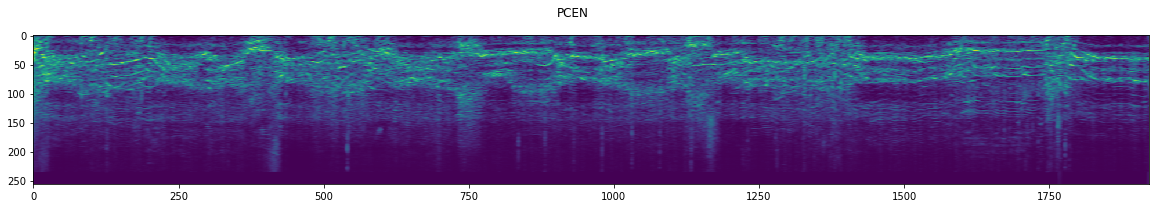

In [4]:
fig = plt.figure(figsize=(20,3))
fig.suptitle("Power to Db")
plt.imshow(power_to_db)


fig = plt.figure(figsize=(20,3))
fig.suptitle("PCEN")
plt.imshow(pcen_librosa)

### Learn the PCEN parameters

The idea of incorporating the tuning of these parameters was appealing so I adapted and simplified code for a PyTorch PCEN layer that I found [here](https://github.com/daemon/pytorch-pcen).

The code there uses different names for the PCEN parameters and it took me a little while to figure exactly how to change the parameter values to be equivalent to the librosa implementation.

A change I found necessary to make was to ensure that the parameters remained positive during training. Initially using the code from github, my gradients would become undefined because the PCEN calculation went wrong if the paramters became negative. 

I followed the approach suggested in the [original paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/8a75d472dc7286653a5245a80a7603a1db308af0.pdf) that proposed PCEN, and learnt the logarithms of the parameters and then exponentiated them in the PCEN calculation.

In [5]:
def pcen(x, eps=1E-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1E-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
        x = x.permute((0,1,3,2)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
        x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

I used the ```PCENTransform``` module above as the first layer in my CNN. 

Something like:


```
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.pcen = PCENTransform(eps=1E-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
   
    ...
    
    def forward(self, x):
        p = self.pcen(x)

    ...

```

### Test PyTorch PCEN definition

The librosa pcen documentation states that:

> If b is not provided, it is calculated as:
> 
> b = (sqrt(1 + 4* T**2) - 1) / (2 * T**2)
> where T = time_constant * sr / hop_length.

In [6]:
t = torch.tensor(s)

T = time_constant * sr / hop_length

b = (math.sqrt(1 + 4* T**2) - 1) / (2 * T**2)    # as per librosa documentation

pcen_torch = pcen(t[None,...].permute((0,2,1)),  # change the shape of the mels appropriately for the PyTorch pcen function
                  eps      = eps, 
                  s        = b, 
                  alpha    = gain,
                  delta    = bias, 
                  r        = power, 
                  training = True)

pcen_torch = pcen_torch.permute((0,2,1)).squeeze().numpy()     # change the shape back and convert to numpy array from tensor

### Check that the PyTorch and Librosa PCEN are the same

In [7]:
np.allclose(pcen_librosa, pcen_torch)

True

### Problem: Slice then PCEN ≠ PCEN then Slice

For this competition to ensure constant input size for my networks I was using the approach of randomly slicing a section of the spectrogram and zero-padding if necessary.

I realised that the order of slicing and PCEN matters:

In [8]:
width  = 256
start  = np.random.randint(0,s.shape[1]-width) 
end    = start + width

crop_then_slice = librosa.core.pcen(s[:,start:end],
                                    sr            = sr,
                                    hop_length    = hop_length,
                                    gain          = gain,
                                    bias          = bias,
                                    power         = power,
                                    time_constant = time_constant,
                                    eps           = eps)

slice_then_crop = pcen_librosa[:,start:end]

In [9]:
np.allclose(crop_then_slice, slice_then_crop)

False

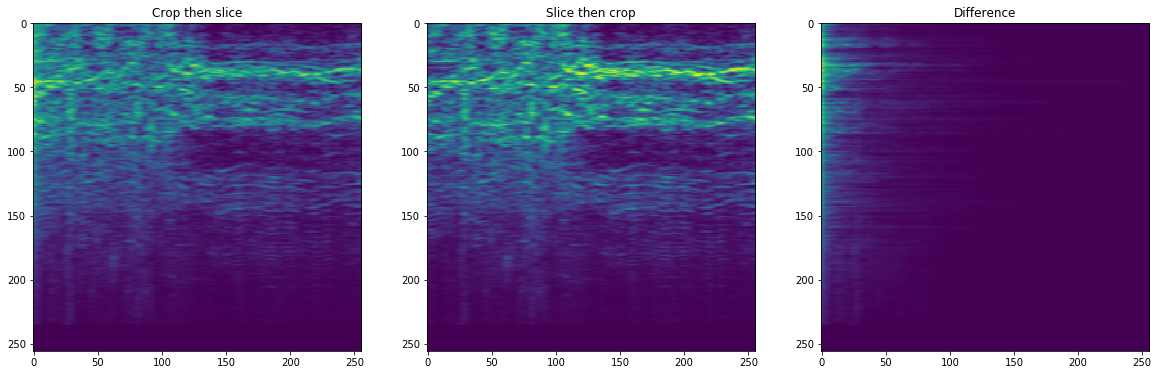

In [10]:
fig, ax = plt.subplots(1,3,figsize=[20,9])
ax[0].set_title("Crop then slice")
ax[0].imshow(crop_then_slice)

ax[1].set_title("Slice then crop")
ax[1].imshow(slice_then_crop)

ax[2].set_title("Difference")
ax[2].imshow(crop_then_slice-slice_then_crop)

When the PCEN is computed on the entire spectrogram information is carried through from the start of the spectrogram, whereas when the slicing is done first this information is not available.

### Trainable PCEN CNN performance

Using a PCEN layer in my network with the above slicing approach posed a bit of a challenge, the PCEN will be computed on the sliced spectrogram not on the whole spectrogram and this seemed to make a difference to my training results.

I found that I could not get the trainable PCEN to perform as well as the static parameters I chose with librosa.

I tried setting my PCEN layer to not be trainable and gave it the same static parameters, but the performance was still worse.

The only thing I can think to attribute this to is the problem I highlighted above.